# Tutorial

In [1]:
%matplotlib inline
import scenicplus
scenicplus.__version__

'0.1.dev89+g8fe3c80'

In this tutorial we describe the minimum steps to generate a SCENIC+ object and build e-GRNs. Detailed tutorials for exploring the results will be provided.

### 1. Create SCENIC+ object 

For generating a SCENIC+ you will require:
* scRNA-seq annData object (e.g. scanpy)
* scATAC-seq cisTopic object
* Pycistarget motif enrichment dictionary

In [2]:
# Load functions
from scenicplus.scenicplus_class import SCENICPLUS, create_SCENICPLUS_object
from scenicplus.preprocessing.filtering import *

First we will load the scRNA-seq and the scATAC-seq data. We make sure that names match between them.

In [3]:
# Load data
## ATAC - cisTopic object
import pickle
infile = open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/atac/pycistopic/10x_multiome_brain_cisTopicObject_noDBL.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()
## Precomputed imputed data
import pickle
infile = open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/atac/pycistopic/DARs/Imputed_accessibility.pkl', 'rb') #Here I am using pycisTopic gene activity matrix, but could be any :)
imputed_acc_obj = pickle.load(infile)
infile.close()
## RNA - Create Anndata
from loomxpy.loomxpy import SCopeLoom
from pycisTopic.loom import *
import itertools
import anndata
path_to_loom = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/rna/seurat/10x_multiome_brain_Seurat.loom'
loom = SCopeLoom.read_loom(path_to_loom)
metadata = get_metadata(loom)
# Fix names
metadata['barcode'] = [x.split('-')[0] for x in metadata.index.tolist()]
metadata['barcode'] = metadata['barcode'] + '-1'
metadata.index = metadata['barcode'] + '-10x_multiome_brain'
expr_mat = loom.ex_mtx
expr_mat.index = metadata['barcode'] + '-10x_multiome_brain'
rna_anndata = anndata.AnnData(X=expr_mat)
rna_anndata.obs = metadata

If you have generated your cisTopic object with an old version of pycisTopic, it is possible that your region data was affected by a previous bug. You can fix it with the code below:

In [4]:
# Fix region data (bug in old pycistopic versions)
from pycisTopic.utils import region_names_to_coordinates
fragment_matrix = cistopic_obj.fragment_matrix
binary_matrix = cistopic_obj.binary_matrix
region_data = region_names_to_coordinates(cistopic_obj.region_names)
region_data['Width'] = abs(region_data.End -region_data.Start).astype(np.int32)
region_data['cisTopic_nr_frag'] = np.array(
fragment_matrix.sum(axis=1)).flatten()
region_data['cisTopic_log_nr_frag'] = np.log10(
region_data['cisTopic_nr_frag'])
region_data['cisTopic_nr_acc'] = np.array(
binary_matrix.sum(axis=1)).flatten()
region_data['cisTopic_log_nr_acc'] = np.log10(
region_data['cisTopic_nr_acc'])
cistopic_obj.region_data = region_data

Next we load the motif enrichment results into a dictionary. We can load motif results from the different methods in pycistarget (e.g. cisTarget, DEM) and different region sets (e.g. topics, DARs, MACS bdgdiff peaks). In this tutorial we will use both cisTarget and DEM peaks from topics and DARs.

In [5]:
# Load cistarget and DEM motif enrichment results
motif_enrichment_dict={}
import pickle
from pycistarget.motif_enrichment_dem import *
path = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/atac/pycistarget/'
infile = open(path +'topics/topic_cistarget_dict.pkl', 'rb')
motif_enrichment_dict['CTX_Topics_All'] = pickle.load(infile)
infile.close()
infile = open(path +'topics/topic_DEM_dict.pkl', 'rb')
motif_enrichment_dict['DEM_Topics_All'] = pickle.load(infile)
infile.close()
infile = open(path +'DARs/DARs_cistarget_dict.pkl', 'rb')
motif_enrichment_dict['CTX_DARs_All'] = pickle.load(infile)
infile.close()
infile = open(path +'DARs/DARs_DEM_dict.pkl', 'rb')
motif_enrichment_dict['DEM_DARs_All'] = pickle.load(infile)
infile.close()

Now we can create the SCENIC+ object:

In [6]:
scplus_obj = create_SCENICPLUS_object(
        GEX_anndata = rna_anndata,
        cisTopic_obj = cistopic_obj,
        imputed_acc_obj = imputed_acc_obj,
        menr = motif_enrichment_dict,
        ACC_prefix = 'ACC_',
        GEX_prefix = 'GEX_',
        bc_transform_func = lambda x: x,
        normalize_imputed_acc = False)

In [7]:
print(scplus_obj)

SCENIC+ object with n_cells x n_genes = 1736 x 26399 and n_cells x n_regions = 1736 x 422146
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_cell:'GEX_VSN_cell_type', 'GEX_VSN_leiden_res0.3', 'GEX_VSN_leiden_res0.6', 'GEX_VSN_leiden_res0.9', 'GEX_VSN_leiden_res1.2', 'GEX_VSN_sample_id', 'GEX_Seurat_leiden_res0.6', 'GEX_Seurat_leiden_res1.2', 'GEX_Seurat_cell_type', 'GEX_barcode', 'ACC_cisTopic_nr_frag', 'ACC_cisTopic_log_nr_acc', 'ACC_barcode', 'ACC_VSN_leiden_res0.6', 'ACC_FRIP', 'ACC_TSS_enrichment', 'ACC_cisTopic_nr_acc', 'ACC_VSN_leiden_res0.9', 'ACC_VSN_RNA+ATAC_leiden_100_2', 'ACC_Dupl_rate', 'ACC_sample_id', 'ACC_pycisTopic_leiden_10_0.6', 'ACC_pycisTopic_leiden_10_1.2', 'ACC_Seurat_leiden_res0.6', 'ACC_Total_nr_frag', 'ACC_Total_nr_frag_in_regions', 'ACC_VSN_leiden_res1.2', 'ACC_VSN_cell_type', 'ACC_Unique_nr_frag_in_regions', 'ACC_Seurat_cell_type', 'ACC_Predicted_doublets_f

You can also filter low accessible regions and low expressed genes. This recommended to avoid getting false relationships with these regions and genes.

In [8]:
filter_genes(scplus_obj, min_pct = 0.5)
filter_regions(scplus_obj, min_pct = 0.5)

2021-11-30 16:28:46,066 Preprocessing INFO     Going from 26399 genes to 20448 genes.
2021-11-30 16:29:07,002 Preprocessing INFO     Going from 422146 regions to 375805 regions.


### 2. Generate cistromes

The next step is to generate cistromes. By default, all targets assigned to a TF across the motif enrichment dictionaries will be taken, and overlapped with regions in the SCENIC+ object. However, it is possible to also subset for regions accessible in certain cell type as well, to generate cell type specific cistromes. This approach is described in the tutorial `cistrome_pruning_advanced.ipynb`.

In [10]:
# Merge cistromes (all)
from scenicplus.cistromes import *
import time
start_time = time.time()
merge_cistromes(scplus_obj)
time = time.time()-start_time
print(time/60)

8.325573766231537


### 3. Optional: Assess TF-cistrome correlation

In addition, cistromes can be pruned based on the correlarion between the presence of a TF and the accessibility of the cistrome. SCENIC+ can be run without this pruning step, deriving eGRNs for each candidate TF, but the assesment of the TF-cistrome correlation can help to prioritize TFs and high confidence GRNs. 

#### A. Score cistromes in cells

The first step is to score the cistromes in each cell. For this purpose, we will use AUCell, using cell rankings based on region accessibility.

In [11]:
# Generate AUC ranking
import time
start_time = time.time()
ranking = make_rankings(scplus_obj)
time = time.time()-start_time
print(time/60)

2.1028337359428404


In [12]:
# Get cistrome enrichment
import time
start_time = time.time()
score_cistromes(scplus_obj,
                ranking,
                cistromes_key = 'Unfiltered',
                enrichment_type = 'region',
                auc_threshold = 0.05,
                normalize = False,
                n_cpu = 8)
time = time.time()-start_time
print(time/60)

5.299575881163279


#### B. Generate pseudobulks

Due to the amount of drop-outs, and the variability in cell types proportions, using directly the AUC cistrome matrix can result in noisy correlations. Here, we use pseudobulks, in which we sample a number of cells per cell type. In this example, we merge 5 cells per pseudobulk and generate 100 pseudobulks per cell type.

In [13]:
import time
start_time = time.time()
generate_pseudobulks(scplus_obj, 
                         variable = 'ACC_Seurat_cell_type',
                         cistromes_key = 'Unfiltered',
                         nr_cells = 5,
                         nr_pseudobulks = 100,
                         seed=555)
time = time.time()-start_time
print(time/60)

1.0027245004971823


#### C. Calculate correlation

Using the pseudobulk TF expression and cistrome AUC matrix we can now assess the correlation between a TF and potential target regions.

In [14]:
import time
start_time = time.time()
TF_cistrome_correlation(scplus_obj,
                        variable = 'ACC_Seurat_cell_type', 
                        cistromes_key = 'Unfiltered',
                        out_key = 'ACC_Seurat_cell_type_unfiltered')
time = time.time()-start_time
print(time/60)

0.02115575075149536


Let's take a look to the TFs we find here:

In [15]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.float_format', lambda x: '%.5f' % x)
display(scplus_obj.uns['TF_cistrome_correlation']['ACC_Seurat_cell_type_unfiltered'].sort_values('Rho', ascending=False))

,TF,Cistrome,Rho,P-value,Adjusted_p-value
627,IKZF1,IKZF1_extended_(5183r),0.92227,0.00000,0.00000
146,IKZF1,IKZF1_(5183r),0.92227,0.00000,0.00000
101,FLI1,FLI1_(10358r),0.90451,0.00000,0.00000
562,FLI1,FLI1_extended_(11104r),0.90302,0.00000,0.00000
805,RUNX1,RUNX1_extended_(507r),0.90160,0.00000,0.00000
302,RUNX1,RUNX1_(507r),0.90160,0.00000,0.00000
635,IRF8,IRF8_extended_(5467r),0.89102,0.00000,0.00000
154,IRF8,IRF8_(5467r),0.89102,0.00000,0.00000
85,EMX2,EMX2_(3365r),0.85297,0.00000,0.00000
546,EMX2,EMX2_extended_(4554r),0.83726,0.00000,0.00000


We can filter cistromes based on their correlation values (or p-value). We recommend however to use these values as a method to prioritize eGRNs, without applying a strict threshold.

In [16]:
print('Number of unfiltered cistromes:')
print(scplus_obj.uns['TF_cistrome_correlation']['ACC_Seurat_cell_type_unfiltered'].shape[0])
print('Number of cistromes with padj < 0.0001:')
print(scplus_obj.uns['TF_cistrome_correlation']['ACC_Seurat_cell_type_unfiltered'][scplus_obj.uns['TF_cistrome_correlation']['ACC_Seurat_cell_type_unfiltered']['Adjusted_p-value'] < 0.0001].shape[0])

Number of unfiltered cistromes:
982
Number of cistromes with padj < 0.0001:
669


In [17]:
# Save
import pickle
with open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/scplus_obj.pkl', 'wb') as f:
  pickle.dump(scplus_obj, f)

#### D. Visualization

##### I. TF expression versus AUC values

We can visualize TF versus cistrome expression:

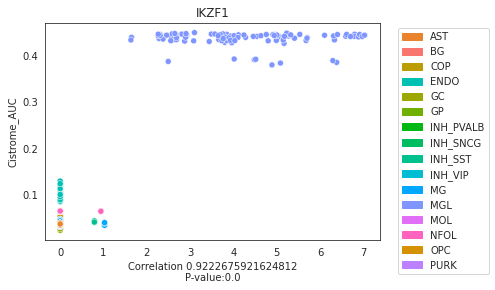

In [19]:
%matplotlib inline
sns.set_style("white")
colors = ["#E9842C","#F8766D", "#BC9D00", "#00C0B4", "#9CA700", "#6FB000", "#00B813", "#00BD61", "#00C08E", "#00BDD4",
           "#00A7FF", "#7F96FF", "#E26EF7", "#FF62BF", "#D69100", "#BC81FF"]
categories = sorted(set(scplus_obj.metadata_cell['ACC_Seurat_cell_type']))
color_dict = dict(zip(categories, colors[0:len(categories)]))
prune_plot(scplus_obj,
           'IKZF1',
           pseudobulk_variable = 'ACC_Seurat_cell_type',
           show_dot_plot = True,
           show_line_plot = False,
           color_dict = color_dict,
           use_pseudobulk = True,
           cistromes_key = 'Unfiltered',
           seed=555)

##### II. Dot plot [TO DO]

### 4. Infer enhancer to gene relationships

To infer enhancer-to-gene relationships, we exploit correlation between region accessibility and gene expression. In addition, to assess no non-linear relationships, we also use Gradient Boosting Machines. More details on these steps can be found in the tutorial `r2g_advanced.ipynb`.

#### A. Get search space

We first need to define the search space around the gene. Here we will use 150kb upstream/downtream the gene, but TAD boundaries can be also used. **WARNING**: Make sure that the specified biomart_host matches your genome assembly. 

In [1]:
import pickle
infile = open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/scplus_obj.pkl', 'rb')
scplus_obj = pickle.load(infile)
infile.close()

In [2]:
from scenicplus.enhancer_to_gene import get_search_space, calculate_regions_to_genes_relationships, GBM_KWARGS
get_search_space(scplus_obj,
                 biomart_host = 'http://www.ensembl.org',
                 species = 'hsapiens',
                 assembly = 'hg38', 
                 upstream = [1000, 150000],
                 downstream = [1000, 150000])

2021-11-30 17:04:19,555 R2G          INFO     Downloading gene annotation from biomart dataset: hsapiens_gene_ensembl
2021-11-30 17:04:45,775 R2G          INFO     Downloading chromosome sizes from: http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes
2021-11-30 17:04:46,976 R2G          INFO     Extending promoter annotation to 10 bp upstream and 10 downstream
2021-11-30 17:04:49,447 R2G          INFO     Extending search space to:
            						150000 bp downstream of the end of the gene.
            						150000 bp upstream of the start of the gene.
2021-11-30 17:05:00,718 R2G          INFO     Intersecting with regions.


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


2021-11-30 17:05:01,864 R2G          INFO     Calculating distances from region to gene
2021-11-30 17:08:31,027 R2G          INFO     Imploding multiple entries per region and gene
2021-11-30 17:10:47,368 R2G          INFO     Done!


#### B. Enhancer-to-gene models

Enhancer-to-gene models can be done using correlation, random forest (RF) or Gradient Boosting Machines (GBM). GBMs are a much faster alternative to RFs.

In [3]:
calculate_regions_to_genes_relationships(scplus_obj, 
                    ray_n_cpu = 20, 
                    _temp_dir = '/scratch/leuven/313/vsc31305/ray_spill',
                    importance_scoring_method = 'GBM',
                    importance_scoring_kwargs = GBM_KWARGS)

2021-11-30 17:13:08,329 R2G          INFO     Calculating region to gene importances, using GBM method


initializing:  15%|█▌        | 2213/14574 [02:55<15:51, 12.99it/s]

(score_regions_to_single_gene_ray pid=9940) 


initializing:  32%|███▏      | 4688/14574 [06:18<13:21, 12.34it/s]

(score_regions_to_single_gene_ray pid=9950) 


initializing:  60%|█████▉    | 8673/14574 [11:46<07:45, 12.67it/s]  

(score_regions_to_single_gene_ray pid=9951) 


initializing:  95%|█████████▍| 13823/14574 [18:25<00:57, 13.01it/s]

(score_regions_to_single_gene_ray pid=10067) 


Running using 20 cores: 100%|██████████| 14574/14574 [00:26<00:00, 545.68it/s] 


2021-11-30 17:33:08,383 R2G          INFO     Took 1200.0518243312836 seconds
2021-11-30 17:33:08,384 R2G          INFO     Calculating region to gene correlation, using SR method


initializing:  79%|███████▉  | 11516/14574 [14:18<03:48, 13.41it/s] 

(score_regions_to_single_gene_ray pid=26168) 


Running using 20 cores: 100%|██████████| 14574/14574 [00:26<00:00, 540.85it/s] 


2021-11-30 17:51:45,732 R2G          INFO     Took 1117.346559047699 seconds
2021-11-30 17:51:57,524 R2G          INFO     Done!


In [4]:
# Save
import pickle
with open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/scplus_obj.pkl', 'wb') as f:
  pickle.dump(scplus_obj, f)

### 5. Infer TF to gene relationships

The next step is to infer relationships between TFs and target genes based on expression. We will use similar approaches as for the enhancer-to-gene relationships (GBM/RF and correlation). 

In [1]:
import pickle
infile = open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/scplus_obj.pkl', 'rb')
scplus_obj = pickle.load(infile)
infile.close()

In [2]:
from scenicplus.TF_to_gene import *
tf_file = '/staging/leuven/stg_00002/lcb/cflerin/resources/allTFs_hg38.txt'
calculate_TFs_to_genes_relationships(scplus_obj, 
                    tf_file = tf_file,
                    ray_n_cpu = 20, 
                    method = 'GBM',
                    _temp_dir = '/scratch/leuven/313/vsc31305/ray_spill',
                    key= 'TF2G_adj')

2021-12-01 13:56:58,895 TF2G         INFO     Calculating TF to gene correlation, using GBM method


initializing:  52%|█████▏    | 10613/20448 [36:07<34:13,  4.79it/s] 

(run_infer_partial_network pid=5684) 


initializing:  62%|██████▏   | 12655/20448 [43:08<26:50,  4.84it/s]  

(run_infer_partial_network pid=5677) 


initializing:  69%|██████▊   | 14052/20448 [47:53<22:06,  4.82it/s]

(run_infer_partial_network pid=5679) 


initializing:  87%|████████▋ | 17848/20448 [1:00:57<10:07,  4.28it/s]  

(run_infer_partial_network pid=5667) 


Running using 20 cores: 100%|██████████| 20448/20448 [01:55<00:00, 177.08it/s] 


2021-12-01 15:11:54,981 TF2G         INFO     Took 4496.082874774933 seconds
2021-12-01 15:11:54,983 TF2G         INFO     Adding correlation coefficients to adjacencies.
2021-12-01 15:13:56,201 TF2G         INFO     Adding importance x rho scores to adjacencies.
2021-12-01 15:13:56,280 TF2G         INFO     Took 121.29756879806519 seconds


In [3]:
# Save
import pickle
with open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/scplus_obj.pkl', 'wb') as f:
  pickle.dump(scplus_obj, f)

If you have run SCENIC before in the gene expression matrix, it is possible to directly load adjancencies from that pipeline:

In [8]:
load_TF2G_adj_from_file(scplus_obj, 
                        f_adj = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/rna/vsn/single_sample_scenic_HQ/out/scenic/10x_multiome_brain_HQ/arboreto_with_multiprocessing/10x_multiome_brain_HQ__adj.tsv', 
                        inplace = True, 
                        key= 'TF2G_adj')

2021-12-01 15:33:03,989 TF2G         INFO     Reading file: /staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/rna/vsn/single_sample_scenic_HQ/out/scenic/10x_multiome_brain_HQ/arboreto_with_multiprocessing/10x_multiome_brain_HQ__adj.tsv
2021-12-01 15:33:16,553 TF2G         INFO     Adding importance x rho scores to adjacencies.
2021-12-01 15:33:16,630 TF2G         INFO     Storing adjacencies in .uns["TF2G_adj"].


### 6. Build eGRNs

The last step is to build the eGRNs using a recovery approach (GSEA). The ranking to use will be based on the TF-2-gene importances, while gene sets will be derived with different thresholding methods on the enhancer-to-gene relationships and the unfiltered cistromes.

In [1]:
import pickle
infile = open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/scplus_obj.pkl', 'rb')
scplus_obj = pickle.load(infile)
infile.close()

In [6]:
# Load functions
from scenicplus.grn_builder.gsea_approach import build_grn

build_grn(scplus_obj,
         min_target_genes = 10,
         adj_pval_thr = 0.05,
         min_regions_per_gene = 0,
         quantiles = (0.85, 0.90, 0.95),
         top_n_regionTogenes_per_gene = (5, 10, 15),
         top_n_regionTogenes_per_region = (),
         binarize_using_basc = False, #To be checked
         rho_dichotomize_tf2g = True,
         rho_dichotomize_r2g = True,
         rho_dichotomize_eregulon = True,
         rho_threshold = 0.05,
         keep_extended_motif_annot = True,
         merge_eRegulons = True, 
         order_regions_to_genes_by = 'importance',
         order_TFs_to_genes_by = 'importance',
         key_added = 'eRegulons_importance',
         disable_tqdm = True, #If running in notebook, set to True
         ray_n_cpu = 15,
         _temp_dir = '/scratch/leuven/313/vsc31305/ray_spill')

2021-12-02 10:58:48,128 GSEA         INFO     Thresholding region to gene relationships
2021-12-02 11:13:09,196 GSEA         INFO     Subsetting TF2G adjacencies for TF with motif.
2021-12-02 11:13:14,501 GSEA         INFO     Running GSEA...


(pid=34772) /opt/venv/lib/python3.8/site-packages/gseapy/algorithm.py:71: RuntimeWarning: divide by zero encountered in true_divide
(pid=34772)   norm_tag =  1.0/sum_correl_tag
(pid=34772) /opt/venv/lib/python3.8/site-packages/gseapy/algorithm.py:74: RuntimeWarning: invalid value encountered in multiply
(pid=34772)   RES = np.cumsum(tag_indicator * correl_vector * norm_tag - no_tag_indicator * norm_no_tag, axis=axis)
(pid=34775) /opt/venv/lib/python3.8/site-packages/gseapy/algorithm.py:71: RuntimeWarning: divide by zero encountered in true_divide
(pid=34775)   norm_tag =  1.0/sum_correl_tag
(pid=34775) /opt/venv/lib/python3.8/site-packages/gseapy/algorithm.py:74: RuntimeWarning: invalid value encountered in multiply
(pid=34775)   RES = np.cumsum(tag_indicator * correl_vector * norm_tag - no_tag_indicator * norm_no_tag, axis=axis)
(pid=34780) /opt/venv/lib/python3.8/site-packages/gseapy/algorithm.py:71: RuntimeWarning: divide by zero encountered in true_divide
(pid=34780)   norm_tag =  

(ray_run_gsea_for_e_module pid=34778) 
2021-12-02 11:33:45,849 GSEA         INFO     Subsetting on adjusted pvalue: 0.05, minimal NES: 0 and minimal leading edge genes 10
2021-12-02 11:33:46,012 GSEA         INFO     Merging eRegulons
2021-12-02 11:33:46,068 GSEA         INFO     Storing eRegulons in .uns[eRegulons_importance].


To access the eGRNs:

In [65]:
scplus_obj.uns['eRegulons_importance']

[eRegulon for TF BCL11A in context frozenset({'0.95 quantile', 'positive tf2g', 'positive r2g', 'Top 5 region-to-gene links per gene', 'Top 10 region-to-gene links per gene', '0.9 quantile', '0.85 quantile', 'Top 15 region-to-gene links per gene', 'Cistromes_Unfiltered'}).
 	This eRegulon has 889 target regions and 706 target genes.,
 eRegulon for TF ELK3 in context frozenset({'Top 15 region-to-gene links per gene', 'Cistromes_Unfiltered', 'positive tf2g', 'positive r2g'}).
 	This eRegulon has 70 target regions and 41 target genes.,
 eRegulon for TF ELK4 in context frozenset({'positive tf2g', 'positive r2g', 'Top 10 region-to-gene links per gene', 'Top 5 region-to-gene links per gene', '0.85 quantile', 'Top 15 region-to-gene links per gene', 'Cistromes_Unfiltered'}).
 	This eRegulon has 221 target regions and 134 target genes.,
 eRegulon for TF EMX2 in context frozenset({'0.95 quantile', 'positive tf2g', 'positive r2g', 'Top 10 region-to-gene links per gene', 'Top 5 region-to-gene link

In [ ]:
# Save
import pickle
with open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/scplus_obj.pkl', 'wb') as f:
  pickle.dump(scplus_obj, f)

### 7. Exploring SCENIC+ results [TO DO]